In [20]:
import squigglepy as sq
import numpy as np
import pandas as pd
from squigglepy.numbers import K, M, B
from chip_estimates_utils import (
    normalize_shares,
    compute_h100_equivalents,
    print_cumulative_summary,
    estimate_chip_sales,
    summarize_quarterly_by_chip,
    summarize_calendar_quarters,
    interpolate_to_calendar_quarters,
    verify_calendar_quarter_interpolation,
)

sq.set_seed(42)
np.random.seed(42)
N_SAMPLES = 5000
H100_TOPS = 1979

Spreadsheet with input data for quarterly TPU revenue, based on Broadcom's fiscal calendar, as well as TPU production mix: https://docs.google.com/spreadsheets/d/1eGk2AAdewEO81vx-YBRTtdlhZvAMstY7vZuHrf3sgNI/edit

In [21]:
# ==============================================
# GOOGLE SHEETS CONFIGURATION
# ==============================================

SPREADSHEET_ID = "1eGk2AAdewEO81vx-YBRTtdlhZvAMstY7vZuHrf3sgNI"

REVENUE_SHEET = "TPU_Revenue"
PROD_MIX_SHEET = "Production_Mix"
PRICES_SHEET = "prices"

# Construct URLs for direct CSV export
REVENUE_URL = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/gviz/tq?tqx=out:csv&sheet={REVENUE_SHEET}"
PROD_MIX_URL = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/gviz/tq?tqx=out:csv&sheet={PROD_MIX_SHEET}"
PRICES_URL = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/gviz/tq?tqx=out:csv&sheet={PRICES_SHEET}"

In [22]:
# ==============================================
# LOAD DATA FROM GOOGLE SHEETS
# ==============================================

revenue_df = pd.read_csv(REVENUE_URL).dropna(axis=1, how="all")
print(f"Loaded {len(revenue_df)} quarters of revenue data")
print(revenue_df[['quarter', 'start_date', 'end_date', 'revenue_p5', 'revenue_p95', 'broadcom_margin_p5', 'broadcom_margin_p95']].head())

prod_mix_df = pd.read_csv(PROD_MIX_URL).dropna(axis=1, how="all")
print(prod_mix_df[['quarter', 'version', 'share_p5', 'share_p95']].head(10))

prices_df = pd.read_csv(PRICES_URL).dropna(axis=1, how="all")
print(prices_df)

Loaded 12 quarters of revenue data
   quarter  start_date    end_date  revenue_p5  revenue_p95  \
0  Q1_FY23  10/31/2022   1/29/2023        0.42         0.53   
1  Q2_FY23   1/30/2023   4/30/2023        0.53         0.66   
2  Q3_FY23    5/1/2023   7/30/2023        0.53         0.66   
3  Q4_FY23   7/31/2023  10/29/2023        0.79         0.99   
4  Q1_FY24  10/30/2023    2/4/2024        1.30         1.45   

   broadcom_margin_p5  broadcom_margin_p95  
0                0.55                 0.70  
1                0.55                 0.70  
2                0.55                 0.70  
3                0.55                 0.70  
4                0.50                 0.65  
   quarter version  share_p5  share_p95
0  Q1_FY23      v4      0.60       0.80
1  Q1_FY23     v4i      0.10       0.20
2  Q1_FY23     v5e      0.10       0.20
3  Q2_FY23      v4      0.60       0.90
4  Q2_FY23     v5e      0.10       0.40
5  Q3_FY23     v5e      0.65       0.95
6  Q3_FY23      v4      0.05       0

In [23]:
# ==============================================
# CONVERT TO SQUIGGLEPY DISTRIBUTIONS
# ==============================================

# Convert revenue DataFrame to dictionary of distributions
TPU_REVENUE = {}
for _, row in revenue_df.iterrows():
    quarter = row['quarter']
    TPU_REVENUE[quarter] = sq.norm(row['revenue_p5'], row['revenue_p95'])


# Convert production mix DataFrame to nested dictionary of distributions
PROD_MIX = {}
for quarter in prod_mix_df['quarter'].unique():
    quarter_data = prod_mix_df[prod_mix_df['quarter'] == quarter]
    PROD_MIX[quarter] = {}
    for _, row in quarter_data.iterrows():
        version = row['version']
        PROD_MIX[quarter][version] = sq.norm(row['share_p5'], row['share_p95'], lclip = 0, rclip = 1)

In [24]:
# ======================
# TPU Specs and Margins
# ======================

# TPU specs: 8-bit TOPS (hardcoded) and manufacturing costs (from Google Sheet)
TPU_TOPS = {
    'v3': 123,
    'v4i': 138,
    'v4': 275,
    'v5e': 393,
    'v5p': 918,
    'v6e': 1836,
    'v7': 4614,
}

TPU_NAMES = {
    'v3': 'TPU v3',
    'v4i': 'TPU v4i',
    'v4': 'TPU v4',
    'v5e': 'TPU v5e',
    'v5p': 'TPU v5p',
    'v6e': 'TPU v6e',
    'v7': 'TPU v7',
}

# Build TPU_SPECS from prices_df (costs from Google Sheet) and hardcoded TOPS
TPU_SPECS = {}
for _, row in prices_df.iterrows():
    version = row['version']
    TPU_SPECS[version] = {
        'tops': TPU_TOPS.get(version, 0),
        'cost': sq.to(row['cost_p5'], row['cost_p95']),
        'full_name': TPU_NAMES.get(version, f'TPU {version}'),
    }

for v, spec in TPU_SPECS.items():
    print(f"  {v}: {spec['tops']} TOPS, cost p5-p95: ${spec['cost'].x:,.0f}-${spec['cost'].y:,.0f}")

# Build per-quarter margin distributions from revenue_df
MARGIN_BY_QUARTER = {}
for _, row in revenue_df.iterrows():
    quarter = row['quarter']
    MARGIN_BY_QUARTER[quarter] = sq.to(row['broadcom_margin_p5'], row['broadcom_margin_p95'])

print("Broadom margins:")
for q in list(MARGIN_BY_QUARTER.keys())[:6]:
    m = MARGIN_BY_QUARTER[q]
    print(f"  {q}: {m.x:.0%}-{m.y:.0%}")


# TPU_SPECS = {
#     'v3':  {'tops': 123,  'cost': sq.to(940, 1400), 'full_name': 'TPU v3'},
#     'v4i': {'tops': 138,  'cost': sq.to(700, 1100), 'full_name': 'TPU v4i'},
#     'v4':  {'tops': 275,  'cost': sq.to(1100, 1500), 'full_name': 'TPU v4'},
#     'v5e': {'tops': 393,  'cost': sq.to(950, 1400), 'full_name': 'TPU v5e'},
#     'v5p': {'tops': 918,  'cost': sq.to(2300, 2900), 'full_name': 'TPU v5p'},
#     'v6e': {'tops': 1836, 'cost': sq.to(1600, 1900), 'full_name': 'TPU v6e'},
#     'v7':  {'tops': 4614, 'cost': sq.to(4600, 5500), 'full_name': 'TPU v7'},
# }
#
# # Broadcom margins (higher in FY23, lower afterward)
# MARGIN_FY23 = sq.to(0.55, 0.70)
# MARGIN = sq.to(0.50, 0.65)

  v3: 123 TOPS, cost p5-p95: $940-$1,400
  v4i: 138 TOPS, cost p5-p95: $700-$1,100
  v4: 275 TOPS, cost p5-p95: $1,100-$1,500
  v5e: 393 TOPS, cost p5-p95: $950-$1,400
  v5p: 918 TOPS, cost p5-p95: $2,300-$2,900
  v6e: 1836 TOPS, cost p5-p95: $1,600-$1,900
  v7: 4614 TOPS, cost p5-p95: $4,600-$5,500
Broadom margins:
  Q1_FY23: 55%-70%
  Q2_FY23: 55%-70%
  Q3_FY23: 55%-70%
  Q4_FY23: 55%-70%
  Q1_FY24: 50%-65%
  Q2_FY24: 50%-65%


In [25]:
def get_price_distribution(version, quarter):
    """Get price distribution for a TPU version in a quarter: cost / (1 - margin)."""
    margin = MARGIN_BY_QUARTER[quarter]
    return TPU_SPECS[version]['cost'] / (1 - margin)

# Pre-compute price distributions for each (version, quarter) combination
PRICE_DIST_BY_QUARTER = {}
for quarter in MARGIN_BY_QUARTER.keys():
    PRICE_DIST_BY_QUARTER[quarter] = {
        version: get_price_distribution(version, quarter) 
        for version in TPU_SPECS
    }

# Define sampling functions which get passed into estimate_chip_sales
def sample_revenue(quarter):
    # draw one sample from the quarter's distribution
    return (TPU_REVENUE[quarter] @ 1) * B

def sample_shares(quarter):
    mix = PROD_MIX[quarter]
    # draw one sample from each version's distribution
    raw_shares = {version: dist @ 1 for version, dist in mix.items()}
    return normalize_shares(raw_shares)

def sample_price(quarter, version):
    return PRICE_DIST_BY_QUARTER[quarter][version] @ 1


# def get_price_distribution(version, is_fy23=False):
#     """Get price distribution for a TPU version: cost / (1 - margin)."""
#     margin = MARGIN_FY23 if is_fy23 else MARGIN
#     return TPU_SPECS[version]['cost'] / (1 - margin)
#
# # Pre-compute price distributions for each version and margin regime
# PRICE_DIST_FY23 = {version: get_price_distribution(version, is_fy23=True) for version in TPU_SPECS}
# PRICE_DIST = {version: get_price_distribution(version, is_fy23=False) for version in TPU_SPECS}
#
# def sample_price(quarter, version):
#     price_dists = PRICE_DIST_FY23 if 'FY23' in quarter else PRICE_DIST
#     return price_dists[version] @ 1

In [26]:
# ==============================================
# TPU PRICE SUMMARY
# ==============================================

N_PRICE_SAMPLES = 10_000

def summarize_price_samples(samples: np.ndarray):
    median = float(np.median(samples))
    p5 = float(np.percentile(samples, 5))
    p95 = float(np.percentile(samples, 95))
    return median, p5, p95

# Group quarters by margin regime for display
fy23_quarters = [q for q in MARGIN_BY_QUARTER.keys() if 'FY23' in q]
post_fy23_quarters = [q for q in MARGIN_BY_QUARTER.keys() if 'FY23' not in q]

# Use a representative quarter from each regime
sample_fy23_quarter = fy23_quarters[0] if fy23_quarters else None
sample_post_fy23_quarter = post_fy23_quarters[0] if post_fy23_quarters else None

if sample_post_fy23_quarter:
    print(f"TPU prices (post-FY23 margin, using {sample_post_fy23_quarter}): median and 90% CI (p5-p95)")
    for version in TPU_SPECS:
        dist = PRICE_DIST_BY_QUARTER[sample_post_fy23_quarter][version]
        samples = np.array([dist @ 1 for _ in range(N_PRICE_SAMPLES)], dtype=float)
        median_price, p5, p95 = summarize_price_samples(samples)
        print(f"  {version}: ${median_price:,.0f}  (90% CI: ${p5:,.0f} - ${p95:,.0f})")

if sample_fy23_quarter:
    print(f"\nTPU prices (FY23 margin, using {sample_fy23_quarter}): median and 90% CI (p5-p95)")
    for version in TPU_SPECS:
        dist = PRICE_DIST_BY_QUARTER[sample_fy23_quarter][version]
        samples = np.array([dist @ 1 for _ in range(N_PRICE_SAMPLES)], dtype=float)
        median_price, p5, p95 = summarize_price_samples(samples)
        print(f"  {version}: ${median_price:,.0f}  (90% CI: ${p5:,.0f} - ${p95:,.0f})")

TPU prices (post-FY23 margin, using Q1_FY24): median and 90% CI (p5-p95)
  v3: $2,690  (90% CI: $2,076 - $3,574)
  v4i: $2,052  (90% CI: $1,553 - $2,787)
  v4: $2,995  (90% CI: $2,400 - $3,853)
  v5e: $2,697  (90% CI: $2,099 - $3,543)
  v5p: $6,014  (90% CI: $4,942 - $7,558)
  v6e: $4,049  (90% CI: $3,411 - $5,093)
  v7: $11,724  (90% CI: $9,827 - $14,579)

TPU prices (FY23 margin, using Q1_FY23): median and 90% CI (p5-p95)
  v3: $3,037  (90% CI: $2,322 - $4,121)
  v4i: $2,338  (90% CI: $1,755 - $3,223)
  v4: $3,399  (90% CI: $2,688 - $4,484)
  v5e: $3,061  (90% CI: $2,357 - $4,102)
  v5p: $6,820  (90% CI: $5,548 - $8,854)
  v6e: $4,604  (90% CI: $3,792 - $5,871)
  v7: $13,277  (90% CI: $10,961 - $17,119)


In [27]:
"""
Run Monte Carlo simulation to estimate chip volumes.

Args:
    quarters: list of quarter identifiers (e.g., ['Q1_FY23', 'Q2_FY23', ...])
    versions: list of chip types (e.g., ['v3', 'v4', 'v5e', ...])
    sample_revenue: fn(quarter) -> float, samples or looks up total chip revenue in dollars for a quarter
    sample_shares: fn(quarter) -> dict, samples {version: share} for a quarter (should sum to 1)
    sample_price: fn(quarter, version) -> float, samples or looks up price for a chip type in a quarter
    n_samples: number of Monte Carlo samples

Returns:
    Dictionary of {quarter: {version: [array of samples of chip unit counts]}}
    To find median, confidence intervals, etc you will need to take the percentiles of the result

Note on cross-quarter correlations:
    The sampling functions are called independently for each quarter within each iteration.
    This means any parameters you want correlated across quarters (e.g., a single margin
    value affecting all quarters) will NOT be correlated by default. To preserve cross-quarter
    correlations, pre-sample those parameters outside this function and have your sampling
    functions reference them.
"""

sim_results = estimate_chip_sales(
    quarters=list(TPU_REVENUE.keys()),
    versions=list(TPU_SPECS.keys()),
    sample_revenue=sample_revenue,
    sample_shares=sample_shares,
    sample_price=sample_price,
    n_samples=N_SAMPLES
)

In [28]:
# Detailed summary with each chip type as separate columns with 90% CI
summary_df = summarize_quarterly_by_chip(sim_results)
print("TPU Production Volumes by Quarter (median with 90% CI)")
print(summary_df.to_string(index=False))

TPU Production Volumes by Quarter (median with 90% CI)
Quarter v3           v4i              v4              v5e              v5p              v6e             v7            Total
Q1_FY23  - 30k (18k-46k)  98k (72k-128k)    23k (14k-35k)                -                -              - 152k (122k-186k)
Q2_FY23  -             - 131k (93k-178k)    47k (21k-77k)                -                -              - 180k (140k-224k)
Q3_FY23  -             -   34k (10k-58k) 155k (110k-216k)                -                -              - 190k (145k-246k)
Q4_FY23  -             -               - 290k (209k-387k)                -                -              - 290k (209k-387k)
Q1_FY24  -             -               - 460k (346k-597k)    23k (12k-35k)                -              - 483k (369k-618k)
Q2_FY24  -             -               - 410k (298k-545k)  122k (90k-159k)                -              - 534k (422k-663k)
Q3_FY24  -             -               - 353k (229k-517k) 159k (104k-222k)   

In [29]:
# Cumulative totals by TPU version
# 
# Note: don't trust the confidence intervals here, because they don't account for correlation across quarters
# This means they are probably too narrow

cumulative = {version: np.zeros(N_SAMPLES) for version in TPU_SPECS}
for quarter in sim_results:
    for version in TPU_SPECS:
        cumulative[version] += np.array(sim_results[quarter][version])

print_cumulative_summary(cumulative, TPU_SPECS, "Cumulative TPU Production (FY23-FY25)")


Cumulative TPU Production (FY23-FY25)
Version           p5          p50          p95
---------------------------------------------
v4i          18,432       30,318       45,856
v4          211,644      263,708      323,640
v5e       2,080,942    2,383,599    2,718,800
v5p         546,886      669,139      792,778
v6e       1,998,789    2,278,763    2,578,787
v7           37,575       80,417      122,958
---------------------------------------------
TOTAL     5,332,348    5,714,148    6,120,081


In [30]:
# Export quarterly volumes by version to CSV
# ===========================================

from datetime import datetime

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Date estimates were generated: {timestamp}"

# map v3, TPUv3, TPU v3 to TPU v3 and so on
def get_tpu_name(version):
    version = version.strip()
    if version.startswith("TPU "):
        return version
    if version.startswith("TPU"):
        return f"TPU {version[3:]}"
    return f"TPU {version}"

# Build a lookup dict from revenue_df for quarter -> (start_date, end_date)
quarter_dates_lookup = {}
for _, row in revenue_df.iterrows():
    q = row['quarter']
    start = row.get('start_date', '')
    end = row.get('end_date', '')
    # Use empty string if values are missing or NaN
    if pd.isna(start):
        start = ''
    if pd.isna(end):
        end = ''
    quarter_dates_lookup[q] = (start, end)

# Create rows for output
rows = []

for quarter in sim_results:
    start_date, end_date = quarter_dates_lookup.get(quarter, ('', ''))
    
    for version in TPU_SPECS:
        arr = np.array(sim_results[quarter][version])
        if arr.sum() > 0:
            # Calculate H100 equivalents
            h100e_arr = arr * (TPU_SPECS[version]['tops'] / H100_TOPS)
            
            rows.append({
                'Name': f"{quarter} - {get_tpu_name(version)}",
                'Chip manufacturer': 'Google',
                'Start date': start_date,
                'End date': end_date,
                'Compute estimate in H100e (median)': int(np.percentile(h100e_arr, 50)),
                'H100e (5th percentile)': int(np.percentile(h100e_arr, 5)),
                'H100e (95th percentile)': int(np.percentile(h100e_arr, 95)),
                'Number of Units': int(np.percentile(arr, 50)),
                'Number of Units (5th percentile)': int(np.percentile(arr, 5)),
                'Number of Units (95th percentile)': int(np.percentile(arr, 95)),
                'Source / Link': '',
                'Notes': generated_note,
                'Chip type': get_tpu_name(version),
                'Last Modified By': '',
                'Last Modified': '',
            })

# Create output dataframe
tpu_timelines = pd.DataFrame(rows)

# Save to CSV
output_path = 'tpu_chip_timelines.csv'
tpu_timelines.to_csv(output_path, index=False)

print(f"Exported to {output_path}")
print(tpu_timelines[['Name', 'Chip manufacturer', 'Start date', 'End date', 
                      'Compute estimate in H100e (median)', 'H100e (5th percentile)', 
                      'H100e (95th percentile)', 'Number of Units', 'Number of Units (5th percentile)',
                      'Number of Units (95th percentile)', 'Chip type']].to_string())

Exported to tpu_chip_timelines.csv
                 Name Chip manufacturer  Start date    End date  Compute estimate in H100e (median)  H100e (5th percentile)  H100e (95th percentile)  Number of Units  Number of Units (5th percentile)  Number of Units (95th percentile) Chip type
0   Q1_FY23 - TPU v4i            Google  10/31/2022   1/29/2023                                2114                    1285                     3197            30318                             18432                              45856   TPU v4i
1    Q1_FY23 - TPU v4            Google  10/31/2022   1/29/2023                               13554                   10015                    17756            97543                             72076                             127785    TPU v4
2   Q1_FY23 - TPU v5e            Google  10/31/2022   1/29/2023                                4606                    2854                     6888            23195                             14372                              3

In [31]:
# ==============================================
# COST VS REVENUE ANALYSIS
# ==============================================
# Compares total chip cost per quarter vs Broadcom revenue

# Build quarters list from sim_results
quarters = list(sim_results.keys())

# Map revenue_df -> dict for lookup (values are in $B)
rev_map = revenue_df.set_index("quarter")[["revenue_p5", "revenue_p95"]].to_dict(orient="index")

def get_chip_draws(quarter, version):
    """Extract chip count draws for (quarter, version) from sim_results."""
    arr = np.asarray(sim_results[quarter][version], dtype=float)
    return arr

def sample_price_draws(quarter, version, n):
    """Sample price draws using quarter-specific margin."""
    dist = PRICE_DIST_BY_QUARTER[quarter][version]
    return np.array([dist @ 1 for _ in range(n)], dtype=float)

def get_broadcom_rev_draws(quarter, n):
    """Sample Broadcom revenue draws for quarter using revenue_df p5/p95 (in $B)."""
    p5_b = float(rev_map[quarter]["revenue_p5"])
    p95_b = float(rev_map[quarter]["revenue_p95"])
    return np.random.uniform(p5_b, p95_b, size=n) * 1e9

# Compute total cost + revenue by quarter
cost_rev_rows = []
for q in quarters:
    total_cost = np.zeros(N_SAMPLES, dtype=float)
    
    # Get versions present this quarter from sim_results
    for v in TPU_SPECS:
        chips_draws = get_chip_draws(q, v)
        if chips_draws.sum() > 0:
            price_draws = sample_price_draws(q, v, N_SAMPLES)
            total_cost += chips_draws * price_draws
    
    rev_draws = get_broadcom_rev_draws(q, N_SAMPLES)
    
    cost_rev_rows.append({
        "quarter": q,
        "total_chip_cost_p5": np.percentile(total_cost, 5),
        "total_chip_cost_p50": np.percentile(total_cost, 50),
        "total_chip_cost_p95": np.percentile(total_cost, 95),
        "broadcom_rev_p5": np.percentile(rev_draws, 5),
        "broadcom_rev_p50": np.percentile(rev_draws, 50),
        "broadcom_rev_p95": np.percentile(rev_draws, 95),
    })

cost_vs_rev_df = pd.DataFrame(cost_rev_rows)

print("Total Chip Cost vs Broadcom Revenue by Quarter")
print(cost_vs_rev_df.to_string(index=False, formatters={
    "total_chip_cost_p5": "${:,.0f}".format,
    "total_chip_cost_p50": "${:,.0f}".format,
    "total_chip_cost_p95": "${:,.0f}".format,
    "broadcom_rev_p5": "${:,.0f}".format,
    "broadcom_rev_p50": "${:,.0f}".format,
    "broadcom_rev_p95": "${:,.0f}".format,
}))

Total Chip Cost vs Broadcom Revenue by Quarter
quarter total_chip_cost_p5 total_chip_cost_p50 total_chip_cost_p95 broadcom_rev_p5 broadcom_rev_p50 broadcom_rev_p95
Q1_FY23       $362,677,946        $481,263,122        $640,775,378    $425,526,638     $475,000,949     $524,559,019
Q2_FY23       $434,726,785        $597,248,901        $820,069,376    $536,658,776     $593,176,305     $652,869,215
Q3_FY23       $424,281,645        $598,162,806        $844,316,517    $536,467,657     $594,505,627     $653,896,226
Q4_FY23       $584,983,077        $896,879,530      $1,341,006,392    $800,191,146     $892,489,928     $980,315,380
Q1_FY24       $984,072,123      $1,372,204,237      $1,944,496,443  $1,308,064,192   $1,377,001,057   $1,443,360,334
Q2_FY24     $1,435,913,317      $1,862,657,692      $2,445,274,454  $1,760,190,754   $1,848,195,520   $1,938,735,830
Q3_FY24     $1,508,252,089      $1,941,111,487      $2,500,022,057  $1,857,884,265   $1,925,285,185   $1,992,614,901
Q4_FY24     $1,78

In [32]:
# ==============================================
# PREPARE DATA FOR VISUALIZATIONS
# ==============================================
import matplotlib.pyplot as plt
import re

# Create export_df with quarter, version, h100e_p50, chips_p50 for visualizations
export_rows = []
for quarter in sim_results:
    for version in TPU_SPECS:
        arr = np.array(sim_results[quarter][version])
        h100e_arr = arr * (TPU_SPECS[version]['tops'] / H100_TOPS)
        export_rows.append({
            'quarter': quarter,
            'version': version,
            'chips_p50': int(np.percentile(arr, 50)),
            'chips_p5': int(np.percentile(arr, 5)),
            'chips_p95': int(np.percentile(arr, 95)),
            'h100e_p50': int(np.percentile(h100e_arr, 50)),
            'h100e_p5': int(np.percentile(h100e_arr, 5)),
            'h100e_p95': int(np.percentile(h100e_arr, 95)),
        })

export_df = pd.DataFrame(export_rows)

# Colors for each TPU version
TPU_COLORS = {
    'v3': 'lightcoral',
    'v4i': '#ffffb3',
    'v4': '#bebada',
    'v5e': '#fb8072',
    'v5p': '#80b1d3',
    'v6e': '#fdb462',
    'v7': '#b3de69',
}

# Canonical version order
CANONICAL_VERSIONS = ['v3', 'v4i', 'v4', 'v5e', 'v5p', 'v6e', 'v7']

# Quarter parsing helpers
_qfy_re = re.compile(r"^Q([1-4])_FY(\d{2})$")

def parse_qfy(qfy: str):
    m = _qfy_re.match(qfy)
    if not m:
        raise ValueError(f"Invalid quarter format: {qfy}")
    return int(m.group(1)), 2000 + int(m.group(2))

def qfy_sort_key(qfy: str):
    q, fy = parse_qfy(qfy)
    return (fy, q)

# Broadcom FY quarter -> calendar label
month_abbr = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
              7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
fq_to_start_month = {1:11, 2:2, 3:5, 4:8}
fq_to_end_month = {1:1, 2:4, 3:7, 4:10}

def fiscal_qfy_to_month_range_label(qfy: str) -> str:
    q, fy = parse_qfy(qfy)
    sm = fq_to_start_month[q]
    em = fq_to_end_month[q]
    start_year = fy - 1 if q == 1 else fy
    end_year = fy
    if q == 1:
        return f"{month_abbr[sm]} '{str(start_year)[-2:]} - {month_abbr[em]} '{str(end_year)[-2:]}"
    else:
        return f"{month_abbr[sm]} - {month_abbr[em]} '{str(end_year)[-2:]}"

print(f"Created export_df with {len(export_df)} rows")
print(export_df.head(10))

Created export_df with 84 rows
   quarter version  chips_p50  chips_p5  chips_p95  h100e_p50  h100e_p5  \
0  Q1_FY23      v3          0         0          0          0         0   
1  Q1_FY23     v4i      30318     18432      45856       2114      1285   
2  Q1_FY23      v4      97543     72076     127785      13554     10015   
3  Q1_FY23     v5e      23195     14372      34689       4606      2854   
4  Q1_FY23     v5p          0         0          0          0         0   
5  Q1_FY23     v6e          0         0          0          0         0   
6  Q1_FY23      v7          0         0          0          0         0   
7  Q2_FY23      v3          0         0          0          0         0   
8  Q2_FY23     v4i          0         0          0          0         0   
9  Q2_FY23      v4     131146     92511     178473      18223     12855   

   h100e_p95  
0          0  
1       3197  
2      17756  
3       6888  
4          0  
5          0  
6          0  
7          0  
8       

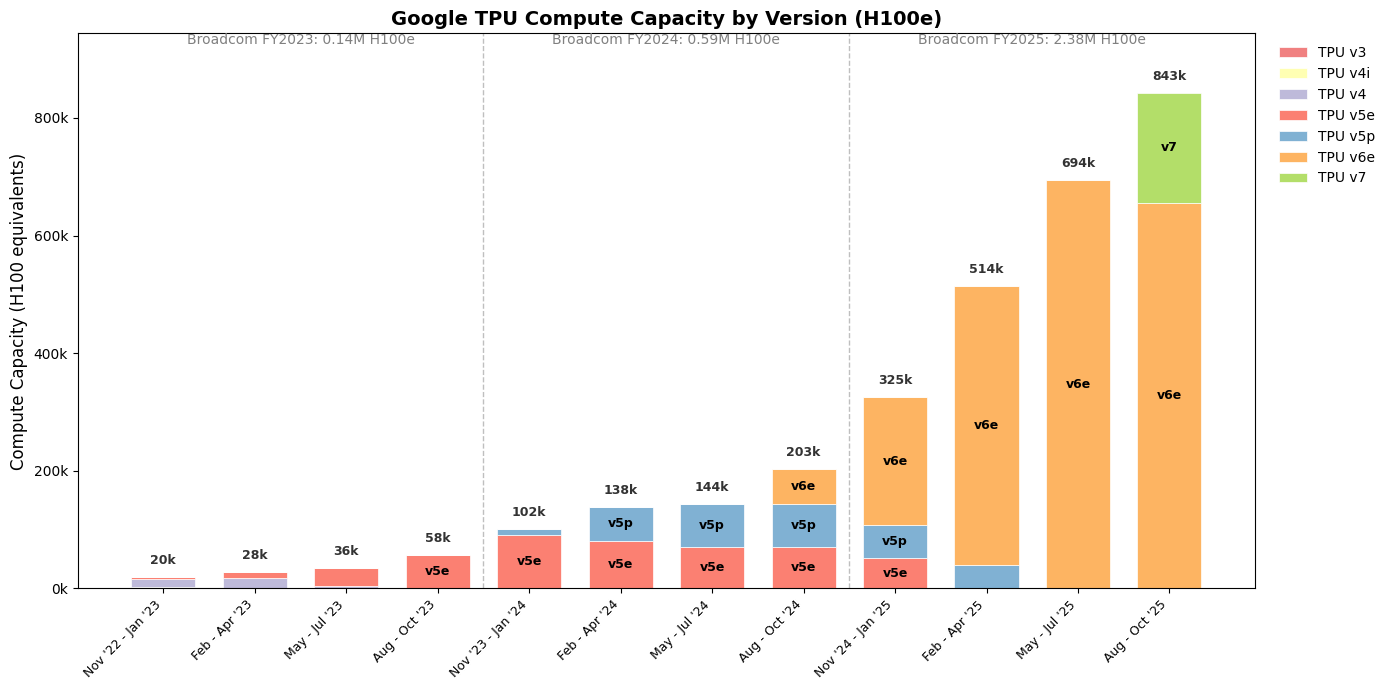

In [33]:
# ==============================================
# VISUALIZATION 1: H100e CAPACITY BY VERSION (STACKED BAR)
# ==============================================

df_plot = export_df.copy()
df_plot['h100e_p50'] = pd.to_numeric(df_plot['h100e_p50'], errors="coerce").fillna(0.0)

# Pivot: quarter x version
pivot = (
    df_plot.pivot_table(index='quarter', columns='version', values='h100e_p50', aggfunc="sum")
    .fillna(0.0)
)

# Sort quarters chronologically
pivot = pivot.reindex(index=sorted(pivot.index, key=qfy_sort_key))

# Order versions
present = [v for v in CANONICAL_VERSIONS if v in pivot.columns]
pivot = pivot.reindex(columns=present, fill_value=0.0)

quarters = pivot.index.tolist()
quarter_labels = [fiscal_qfy_to_month_range_label(q) for q in quarters]

# Convert to thousands of H100e
data = pivot / 1000.0
totals = data.sum(axis=1).values

# FY totals
def fiscal_year_total(fy: int) -> float:
    mask = pivot.index.astype(str).str.contains(f"FY{str(fy)[-2:]}")
    return pivot.loc[mask].sum().sum() / 1000.0

fy23_total = fiscal_year_total(2023)
fy24_total = fiscal_year_total(2024)
fy25_total = fiscal_year_total(2025)

# Separator positions
def separator_after(qfy_target: str):
    if qfy_target in quarters:
        return quarters.index(qfy_target) + 0.5
    return None

sep1 = separator_after("Q4_FY23")
sep2 = separator_after("Q4_FY24")

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(quarters))
width = 0.7

bottom = np.zeros(len(quarters))
for v in data.columns:
    vals = data[v].values
    ax.bar(x, vals, width, bottom=bottom, label=f"TPU {v}", color=TPU_COLORS.get(v), edgecolor="white", linewidth=0.5)
    
    # Segment labels (>= 40k H100e)
    for i, val in enumerate(vals):
        if val >= 40:
            ax.text(x[i], bottom[i] + val / 2, v, ha="center", va="center", fontsize=9, fontweight="bold")
    
    bottom += vals

# Total labels
pad = max(2, 0.02 * max(totals)) if len(totals) else 2
for i, total in enumerate(totals):
    ax.text(x[i], total + pad, f"{total:,.0f}k", ha="center", va="bottom", fontsize=9, fontweight="bold", color="#333333")

ax.set_ylabel("Compute Capacity (H100 equivalents)", fontsize=12)
ax.set_title("Google TPU Compute Capacity by Version (H100e)", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(quarter_labels, rotation=45, ha="right", fontsize=9)
ax.set_ylim(0, max(totals) * 1.12 if len(totals) else 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:,.0f}k"))

# FY separators
if sep1 is not None:
    ax.axvline(x=sep1, color="gray", linestyle="--", alpha=0.5, linewidth=1)
if sep2 is not None:
    ax.axvline(x=sep2, color="gray", linestyle="--", alpha=0.5, linewidth=1)

# FY labels
y_top = ax.get_ylim()[1] * 0.98
for fy, total in [(2023, fy23_total), (2024, fy24_total), (2025, fy25_total)]:
    idxs = [i for i, q in enumerate(quarters) if q.endswith(f"FY{str(fy)[-2:]}")]
    if idxs:
        ax.text(np.mean(idxs), y_top, f"Broadcom FY{fy}: {total/1000:.2f}M H100e", ha="center", fontsize=10, color="gray")

ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1), frameon=False)
plt.tight_layout()
plt.show()

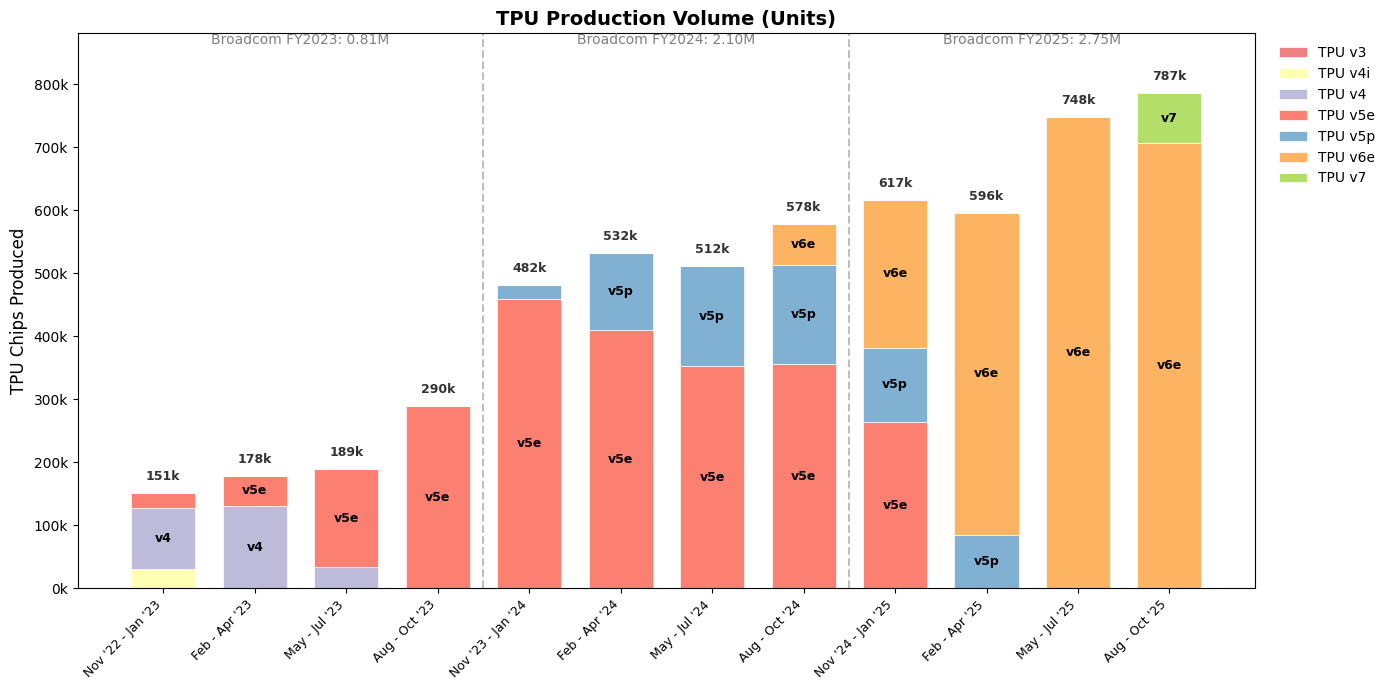

In [34]:
# ==============================================
# VISUALIZATION: TPU UNIT VOLUMES BY VERSION
# ==============================================

df = export_df[['quarter', 'version', 'chips_p50']].copy()
df['chips_p50'] = pd.to_numeric(df['chips_p50'], errors="coerce")

# Pivot
pivot = (
    df.pivot_table(index='quarter', columns='version', values='chips_p50', aggfunc="sum")
    .fillna(0.0)
)

# Sort and order
pivot = pivot.reindex(index=sorted(pivot.index, key=qfy_sort_key))
present = [v for v in CANONICAL_VERSIONS if v in pivot.columns]
pivot = pivot.reindex(columns=present, fill_value=0.0)

quarters = pivot.index.tolist()
quarter_labels = [fiscal_qfy_to_month_range_label(q) for q in quarters]

# Convert to thousands
data_k = pivot / 1000.0
totals_k = data_k.sum(axis=1).values

# FY totals
def fiscal_year_total_k(fy_full: int) -> float:
    fy_suffix = str(fy_full)[-2:]
    mask = pivot.index.str.endswith(f"FY{fy_suffix}")
    return pivot.loc[mask].to_numpy().sum() / 1000.0

fy23_total_k = fiscal_year_total_k(2023)
fy24_total_k = fiscal_year_total_k(2024)
fy25_total_k = fiscal_year_total_k(2025)

# FY separators
def separator_after(qfy_target: str):
    if qfy_target in quarters:
        return quarters.index(qfy_target) + 0.5
    return None

sep1 = separator_after("Q4_FY23")
sep2 = separator_after("Q4_FY24")

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(quarters))
width = 0.7

bottom = np.zeros(len(quarters))

for v in data_k.columns:
    vals = data_k[v].values
    ax.bar(x, vals, width, bottom=bottom, label=f"TPU {v}", color=TPU_COLORS.get(v), edgecolor="white", linewidth=0.5)
    
    # Segment labels (>= 40k units)
    for i, val in enumerate(vals):
        if val >= 40:
            ax.text(x[i], bottom[i] + val / 2, v, ha="center", va="center", fontsize=9, fontweight="bold", color="black")
    
    bottom += vals

# Total labels
pad = max(15, 0.02 * max(totals_k))
for i, total in enumerate(totals_k):
    ax.text(x[i], total + pad, f"{total:,.0f}k", ha="center", va="bottom", fontsize=9, fontweight="bold", color="#333333")

ax.set_ylabel("TPU Chips Produced", fontsize=12)
ax.set_title("TPU Production Volume (Units)", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(quarter_labels, rotation=45, ha="right", fontsize=9)
ax.set_ylim(0, max(totals_k) * 1.12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:,.0f}k"))

# FY separators
if sep1 is not None:
    ax.axvline(sep1, color="gray", linestyle="--", alpha=0.5)
if sep2 is not None:
    ax.axvline(sep2, color="gray", linestyle="--", alpha=0.5)

# FY labels
y_top = ax.get_ylim()[1] * 0.98
def fy_center_x(fy_full: int):
    fy_suffix = str(fy_full)[-2:]
    idxs = [i for i, q in enumerate(quarters) if q.endswith(f"FY{fy_suffix}")]
    return float(np.mean(idxs)) if idxs else None

for fy_full, total_k in [(2023, fy23_total_k), (2024, fy24_total_k), (2025, fy25_total_k)]:
    cx = fy_center_x(fy_full)
    if cx is not None:
        ax.text(cx, y_top, f"Broadcom FY{fy_full}: {total_k/1000:.2f}M", ha="center", fontsize=10, color="gray")

ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1), frameon=False)
plt.tight_layout()
plt.show()

In [35]:
# ==============================================
# INTERPOLATE TO CALENDAR QUARTERS
# ==============================================
# First computes median and 90% CI for each chip/quarter, then interpolates
# to calendar quarters by taking weighted averages of these summary statistics
# based on the day overlap between fiscal and calendar quarters.

# Build quarter_dates dict from revenue_df
quarter_dates = {}
for _, row in revenue_df.iterrows():
    quarter_dates[row['quarter']] = (row['start_date'], row['end_date'])

# Interpolate to calendar quarters
calendar_results = interpolate_to_calendar_quarters(sim_results, quarter_dates)

# Display summary using summarize_calendar_quarters
calendar_summary = summarize_calendar_quarters(calendar_results)
print("\nTPU Production Volumes by Calendar Quarter (median with 90% CI)")
print(calendar_summary.to_string(index=False))

# verify_calendar_quarter_interpolation(sim_results, calendar_results, quarter_dates)


TPU Production Volumes by Calendar Quarter (median with 90% CI)
Quarter v3           v4i              v4              v5e              v5p              v6e            v7             Total
Q4 2022  - 21k (13k-31k)   66k (49k-87k)    16k (10k-24k)                -                -             -   103k (71k-142k)
Q1 2023  -  10k (6k-15k) 119k (85k-160k)    39k (19k-63k)                -                -             -  168k (110k-238k)
Q2 2023  -             -   66k (37k-98k)  120k (81k-170k)                -                -             -  186k (118k-268k)
Q3 2023  -             -    11k (3k-19k) 249k (179k-335k)                -                -             -  260k (182k-354k)
Q4 2023  -             -               - 388k (289k-507k)     15k (7k-22k)                -             -  403k (296k-529k)
Q1 2024  -             -               - 416k (307k-548k)   83k (59k-110k)                -             -  500k (366k-659k)
Q2 2024  -             -               - 375k (255k-528k)  145k (98

In [36]:
# ==============================================
# EXPORT INTERPOLATED CALENDAR QUARTER RESULTS
# ==============================================
# Same format as tpu_chip_timelines.csv but using calendar quarters

from datetime import datetime

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Date estimates were generated: {timestamp}"

# Calendar quarter to date range mapping
def get_calendar_quarter_dates(cal_q):
    """Return (start_date, end_date) strings for a calendar quarter like 'Q1 2024'."""
    parts = cal_q.split()
    q_num = int(parts[0][1])
    year = int(parts[1])
    if q_num == 1:
        return f"1/1/{year}", f"3/31/{year}"
    elif q_num == 2:
        return f"4/1/{year}", f"6/30/{year}"
    elif q_num == 3:
        return f"7/1/{year}", f"9/30/{year}"
    else:
        return f"10/1/{year}", f"12/31/{year}"

# Create rows for output
rows = []

for quarter in calendar_results:
    start_date, end_date = get_calendar_quarter_dates(quarter)
    
    for version in TPU_SPECS:
        stats = calendar_results[quarter][version]
        if stats['p50'] > 0:
            # Calculate H100 equivalents
            h100e_factor = TPU_SPECS[version]['tops'] / H100_TOPS
            
            rows.append({
                'Name': f"{quarter} - {get_tpu_name(version)}",
                'Chip manufacturer': 'Google',
                'Start date': start_date,
                'End date': end_date,
                'Compute estimate in H100e (median)': int(stats['p50'] * h100e_factor),
                'H100e (5th percentile)': int(stats['p5'] * h100e_factor),
                'H100e (95th percentile)': int(stats['p95'] * h100e_factor),
                'Number of Units': int(stats['p50']),
                'Number of Units (5th percentile)': int(stats['p5']),
                'Number of Units (95th percentile)': int(stats['p95']),
                'Source / Link': '',
                'Notes': generated_note,
                'Chip type': get_tpu_name(version),
                'Last Modified By': '',
                'Last Modified': '',
            })

# Create output dataframe
tpu_timelines_interpolated = pd.DataFrame(rows)

# Save to CSV
output_path = 'tpu_timelines_interpolated.csv'
tpu_timelines_interpolated.to_csv(output_path, index=False)

print(f"Exported to {output_path}")
print(tpu_timelines_interpolated[['Name', 'Chip manufacturer', 'Start date', 'End date', 
                                   'Compute estimate in H100e (median)', 'H100e (5th percentile)', 
                                   'H100e (95th percentile)', 'Number of Units', 'Number of Units (5th percentile)',
                                   'Number of Units (95th percentile)', 'Chip type']].to_string())

Exported to tpu_timelines_interpolated.csv
                 Name Chip manufacturer Start date    End date  Compute estimate in H100e (median)  H100e (5th percentile)  H100e (95th percentile)  Number of Units  Number of Units (5th percentile)  Number of Units (95th percentile) Chip type
0   Q4 2022 - TPU v4i            Google  10/1/2022  12/31/2022                                1440                     875                     2178            20656                             12558                              31242   TPU v4i
1    Q4 2022 - TPU v4            Google  10/1/2022  12/31/2022                                9234                    6823                    12098            66457                             49107                              87062    TPU v4
2   Q4 2022 - TPU v5e            Google  10/1/2022  12/31/2022                                3138                    1944                     4693            15803                              9792                           